Goals
* Box + vanishing point -> 3D image
* Manual detection of box?
```
─────────────────────────────**──────────
───▐▀▄───────▄▀▌───▄▄▄▄▄▄▄─────────────
───▌▒▒▀▄▄▄▄▄▀▒▒▐▄▀▀▒██▒██▒▀▀▄──────────
──▐▒▒▒▒▀▒▀▒▀▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▀▄────────
──▌▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▄▒▒▒▒▒▒▒▒▒▒▒▒▀▄──────
▀█▒▒▒█▌▒▒█▒▒▐█▒▒▒▀▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▌─────
▀▌▒▒▒▒▒▒▀▒▀▒▒▒▒▒▒▀▀▒▒▒▒▒▒▒▒▒▒▒▒▒▒▐───▄▄
▐▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▌▄█▒█
▐▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒█▒█▀─
▐▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒█▀───
▐▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▌────
─▌▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▐─────
─▐▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▌─────
──▌▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▐──────
──▐▄▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▄▌──────
────▀▄▄▀▀▀▀▀▄▄▀▀▀▀▀▀▀▄▄▀▀▀▀▀▄▄▀────────
```**

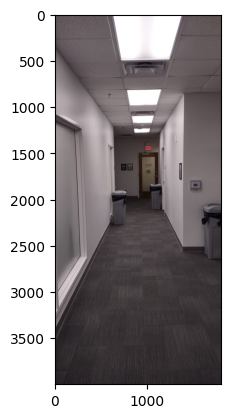

In [107]:
import numpy as np
import numpy.linalg as la
import cv2
import matplotlib.pyplot as plt
import numpy.linalg as linalg

import utils

image = cv2.imread("./pictures/Hallway2.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
from utils.io import read_image, write_image, read_hdr_image, write_hdr_image
from utils.display import display_images_linear_rescale, rescale_images_linear
from utils.hdr_helpers import gsolve
from utils.hdr_helpers import get_equirectangular_image
from utils.bilateral_filter import bilateral_filter

plt.imshow(image_rgb)
plt.show()

Computing Homography 

In [117]:
# box coordinates
box = np.array(
	[[(638,  1336), (1116,  1336)],
	 [(638, 1967), (1116, 1967)] ]
)

# vanishing point the image is a bit offcenter
vp = np.array((923, 1607))


width_box  = np.average(box[:,1,0] - box[:,0,0])
height_box = np.average(box[1,:,1] - box[0,:,1])

print(width_box)
print(height_box)

478.0
631.0


Compute Depth

In [118]:
# Computing Depth

fstop = 1.7
focal_length_mm = 5 # TODO use package to auto import from iamges
aperture_diameter_mm = focal_length_mm / fstop


# bottom = np.average([box[1,0], box[1,1]])
# dv = vp[1] - bottom

# compute dimensions of box
# f / (va - v0) = d / H
depth = focal_length_mm * height_box / (aperture_diameter_mm / 2)
print(depth) 

2145.3999999999996


Compute homography

In [119]:
# compute points for floor
# extend line
alpha = 2 # TODO calculate depth of close_box from alpha
close_box = vp * (1 - alpha) + box * alpha

# length
box_lengths = la.norm(close_box - box, axis=-1)

# this will take all the box coordinates and stretch them out
# which basically draws a wall parallel to the back wall that is closer to you
print(box)
print(close_box)
print(box_lengths)

left_box = np.stack([close_box[:,0], box[:,0]], axis=1)
right_box = np.stack([box[:,1], close_box[:, 1]], axis=1)
top_box = np.stack([close_box[0,:], box[0,:]], axis=0)
bottom_box = np.stack([box[1,:], close_box[1,:]], axis=0)


# fov = 2 * np.arctan(depth/(2 * focal_length_mm)) # angle

tan_fov = (aperture_diameter_mm/2) / focal_length_mm
camera_height = 1 # TODO I think we have to do this
hidden_depth = 1/tan_fov * camera_height
visible_depth = depth - hidden_depth

[[[ 638 1336]
  [1116 1336]]

 [[ 638 1967]
  [1116 1967]]]
[[[ 353 1065]
  [1309 1065]]

 [[ 353 2327]
  [1309 2327]]]
[[393.27598452 332.70106703]
 [459.15683595 408.47154124]]


In [120]:
# homography
# p' = Hp

def computeHomography(top, bottom, height, depth):
    '''
    Compute homography that maps from pts1 to pts2 using SVD. Normalization is optional.
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    # TO DO
    # create A
    A = np.zeros((8, 9))
    
    # TOP LEFT
    u = top[0,0]
    v = top[0,1]

    u_prime = 0
    v_prime = 0
    A[0] = (-u,-v,-1, 0,0,0, u * u_prime, v * u_prime, u_prime)
    A[1] = (0,0,0, -u, -v, - 1, u * v_prime, v * v_prime, v_prime)


    # TOP RIGHT

    u = top[1,0]
    v = top[1,1]

    u_prime = depth
    v_prime = 0
    A[2] = (-u,-v,-1, 0,0,0, u * u_prime, v * u_prime, u_prime)
    A[3] = (0,0,0, -u, -v, - 1, u * v_prime, v * v_prime, v_prime)

    # BOTTOM LEFT

    u = bottom[0,0]
    v = bottom[0,1]

    u_prime = 0
    v_prime = height
    A[4] = (-u,-v,-1, 0,0,0, u * u_prime, v * u_prime, u_prime)
    A[5] = (0,0,0, -u, -v, - 1, u * v_prime, v * v_prime, v_prime)


    # BOTTOM RIGHT

    u = bottom[1,0]
    v = bottom[1,1]

    u_prime = depth
    v_prime = height
    A[6] = (-u,-v,-1, 0,0,0, u * u_prime, v * u_prime, u_prime)
    A[7] = (0,0,0, -u, -v, - 1, u * v_prime, v * v_prime, v_prime)



    U, S, V= linalg.svd(A)

    V_T = V[-1].T
    H = V_T.reshape(3,3)

    return H

Compute Left Side of the Room

[[ 2.56714337e-03  1.94297703e-14 -9.06201608e-01]
 [-5.51264542e-04  5.79743153e-04 -4.22830075e-01]
 [-2.68529641e-06  3.10081821e-17  2.47852858e-03]]


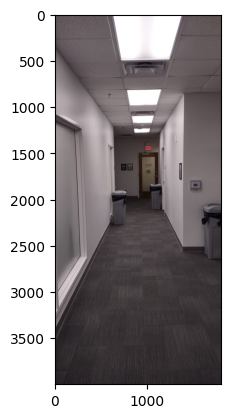

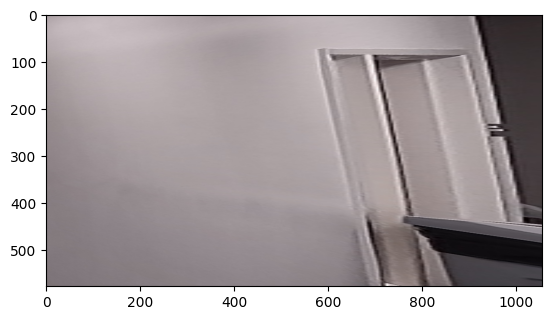

In [121]:
# Compute Left

width = int(width_box)

H = computeHomography(left_box[0], left_box[1], width, 2 * width)
print(H)

plt.figure()
plt.imshow(image_rgb)


projectedWidth = 2 * width + 100
projectedHeight = width + 100
Tr = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]).astype('float32')

# TO DO: warp and blend the two images
# images location
# Load an color image in grayscale
projIm1 = cv2.warpPerspective(image_rgb, 
							  Tr@H, 
							  (projectedWidth, 
		  					   projectedHeight))
plt.figure()
plt.imshow(projIm1)

Compute Top of the Room

[[-3.85255806e-04  4.05158320e-04 -2.95498311e-01]
 [-2.41516876e-15 -8.97034736e-04  9.55341994e-01]
 [ 5.30174862e-17  7.10804070e-07 -1.14226214e-03]]


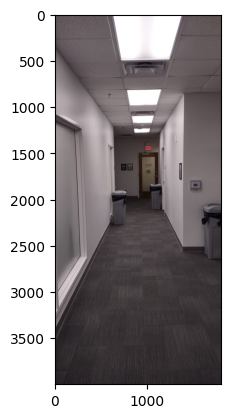

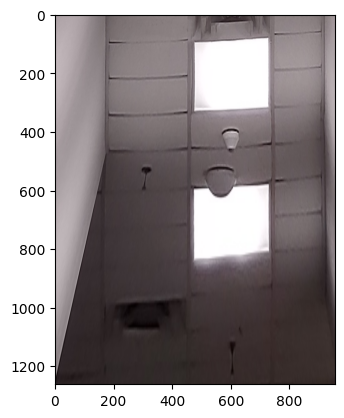

In [122]:
# Compute TOP

width = int(2 * width_box)
height = int(2 * height_box)

H = computeHomography(top_box[0], top_box[1], height, width)
print(H)

plt.figure()
plt.imshow(image_rgb)


projectedWidth = width
projectedHeight = height
Tr = np.array([[1, 0, 10], [0, 1, 0], [0, 0, 1]]).astype('float32')

# TO DO: warp and blend the two images
# images location
# Load an color image in grayscale
projIm1 = cv2.warpPerspective(image_rgb, 
							  Tr@H, 
							  (projectedWidth, 
		  					   projectedHeight))
plt.figure()
plt.imshow(projIm1)

Compute Right Side of the Room

[[-8.32592903e-04  2.05734410e-14  9.29173679e-01]
 [-1.78789760e-04 -1.27329976e-04  3.69642220e-01]
 [-4.35456539e-07 -4.86264674e-17  4.01926385e-04]]


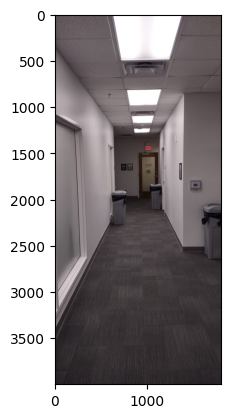

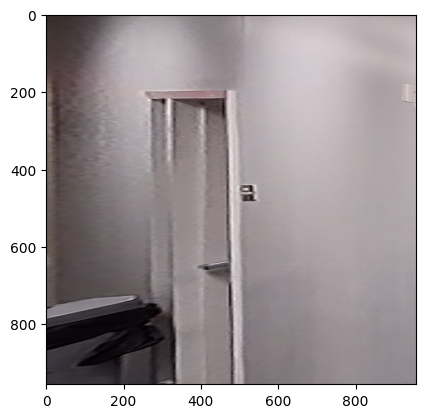

In [123]:
# Compute Left

width = int(2 * width_box)
height = int(2 * height_box)

H = computeHomography(right_box[0], right_box[1], width, width)
print(H)

plt.figure()
plt.imshow(image_rgb)


projectedWidth = width
projectedHeight = width
Tr = np.array([[1, 0, 10], [0, 1, 0], [0, 0, 1]]).astype('float32')

# TO DO: warp and blend the two images
# images location
# Load an color image in grayscale
projIm1 = cv2.warpPerspective(image_rgb, 
							  Tr@H, 
							  (projectedWidth, 
		  					   projectedHeight))
plt.figure()
plt.imshow(projIm1)

Compute the Floor

[[-2.17576111e-04 -2.96967051e-04  6.05649882e-01]
 [ 4.98169214e-15 -6.50106935e-04  7.95730889e-01]
 [ 8.32125167e-18 -1.87242781e-07  1.20397108e-04]]


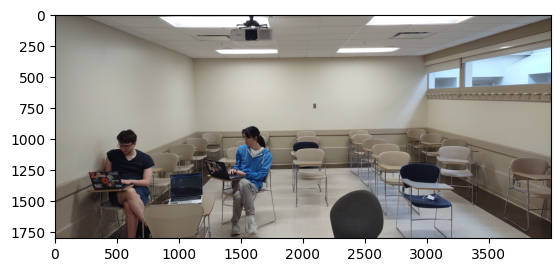

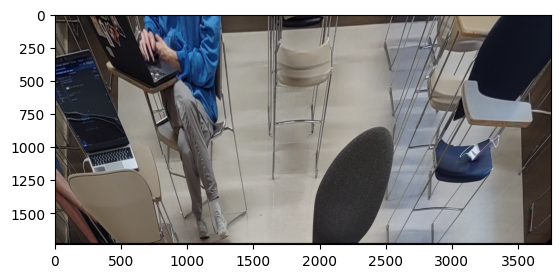

In [106]:
# Compute Left

width = int(2 * width_box)
height = int(2 * height_box)

H = computeHomography(bottom_box[0], bottom_box[1], height, width)
print(H)

plt.figure()
plt.imshow(image_rgb)


projectedWidth = width
projectedHeight = height
Tr = np.array([[1, 0, 10], [0, 1, 0], [0, 0, 1]]).astype('float32')

# TO DO: warp and blend the two images
# images location
# Load an color image in grayscale
projIm1 = cv2.warpPerspective(image_rgb, 
							  Tr@H, 
							  (projectedWidth, 
		  					   projectedHeight))
plt.figure()
plt.imshow(projIm1)